In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [107]:
block_size = 3
def build_dataset(words):  
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [152]:
# MLP revisited
n_embd = 2 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * 1/(n_embd * block_size)**0.5
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [155]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

epsilon = 1e-5

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, biases pointless when batch norm because of bnbias
    # batch norm layer
    # --------------------------------------------------------------------------------
    epsilon = 10e-7
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + epsilon) + bnbias # epsilon to stop /0

    with torch.no_grad(): # not suing these for backprop only for train in the end so no need to make a differentition graph 
        bnmean_running = 0.999 * bnmean_running + (1-0.999) * bnmeani # soft update
        bnstd_running = 0.999 * bnstd_running + (1-0.999) * bnstdi # soft update
    # --------------------------------------------------------------------------------    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 100000: 2.5133
   1000/ 100000: 2.0784
   2000/ 100000: 2.0103
   3000/ 100000: 2.1512
   4000/ 100000: 2.2069
   5000/ 100000: 2.1391
   6000/ 100000: 2.1970
   7000/ 100000: 2.2012
   8000/ 100000: 2.1635
   9000/ 100000: 1.9457
  10000/ 100000: 2.6081
  11000/ 100000: 2.1996
  12000/ 100000: 2.2106
  13000/ 100000: 2.1477
  14000/ 100000: 2.3670
  15000/ 100000: 2.2677
  16000/ 100000: 2.2410
  17000/ 100000: 2.3291
  18000/ 100000: 2.2905
  19000/ 100000: 2.4142
  20000/ 100000: 2.3250
  21000/ 100000: 2.2346
  22000/ 100000: 2.2480
  23000/ 100000: 1.7928
  24000/ 100000: 2.0835
  25000/ 100000: 1.9336
  26000/ 100000: 2.4075
  27000/ 100000: 2.3886
  28000/ 100000: 2.3260
  29000/ 100000: 2.0987
  30000/ 100000: 2.1465
  31000/ 100000: 2.0463
  32000/ 100000: 2.3627
  33000/ 100000: 2.5858
  34000/ 100000: 2.1417
  35000/ 100000: 2.3152
  36000/ 100000: 2.2908
  37000/ 100000: 2.0687
  38000/ 100000: 2.3146
  39000/ 100000: 2.2423
  40000/ 100000: 2.4228
  41000/ 100000:

## Initialization

In [133]:
# loss expected at initilasation: flat priors for the characters 1/27 
exp_loss = -torch.tensor(1/27).log()
print(exp_loss)
# need logits to be all ~equal and small so that the nll is low to avoid fake confidence in incorrect answers such as:
factors = [10, 1, 0.1, 0] 
for factor in factors:
    logits = torch.randn(4) * factor
    probs = torch.softmax(logits, dim=0)
    nll = -torch.log(probs).mean()
    print(nll)


tensor(3.2958)
tensor(9.8790)
tensor(1.6233)
tensor(1.3875)
tensor(1.3863)


## Look At The tanh Layer

In [134]:
# the gradients of y = tanhx are ~0 for large mod(x) which kills gradients flowing through the network. 
# the gradient flowing throgh tanh can only ever drecrease. 

In [157]:
h.shape

torch.Size([32, 200])

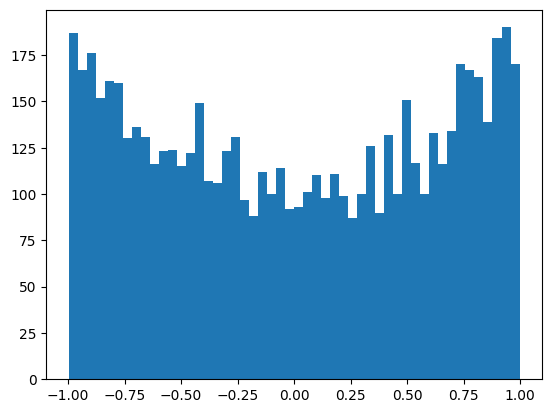

In [135]:
plt.hist(h.view(-1).tolist(), 50);

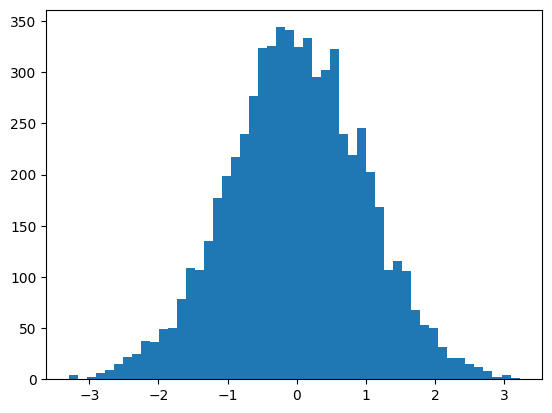

In [136]:
plt.hist(hpreact.view(-1).tolist(), 50);

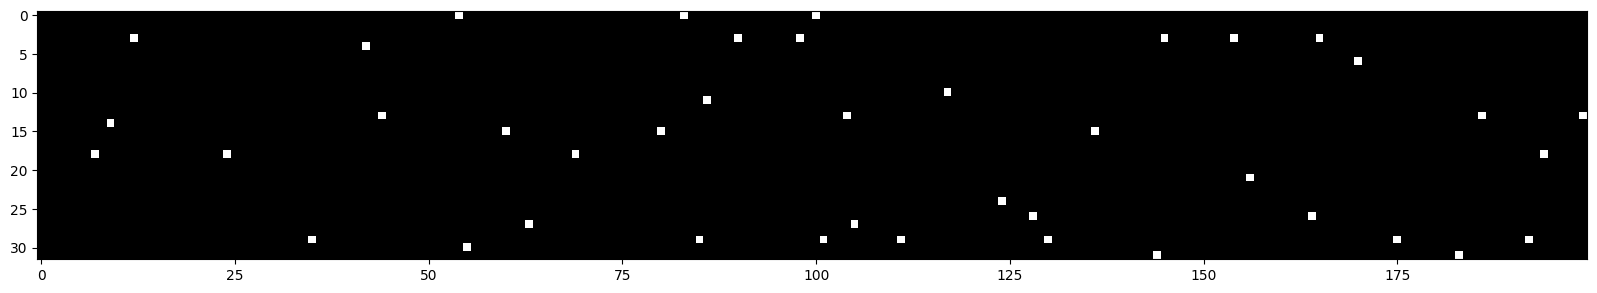

In [137]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest')
# an entire white column (1 of 200 neurons) shows that the neuron always kills the gradient for all of the examples
# in the minibatch --> dead neuron.

# Kaiming Initiation 

tensor(-0.0069) tensor(0.9913)
tensor(0.0009) tensor(0.9816)


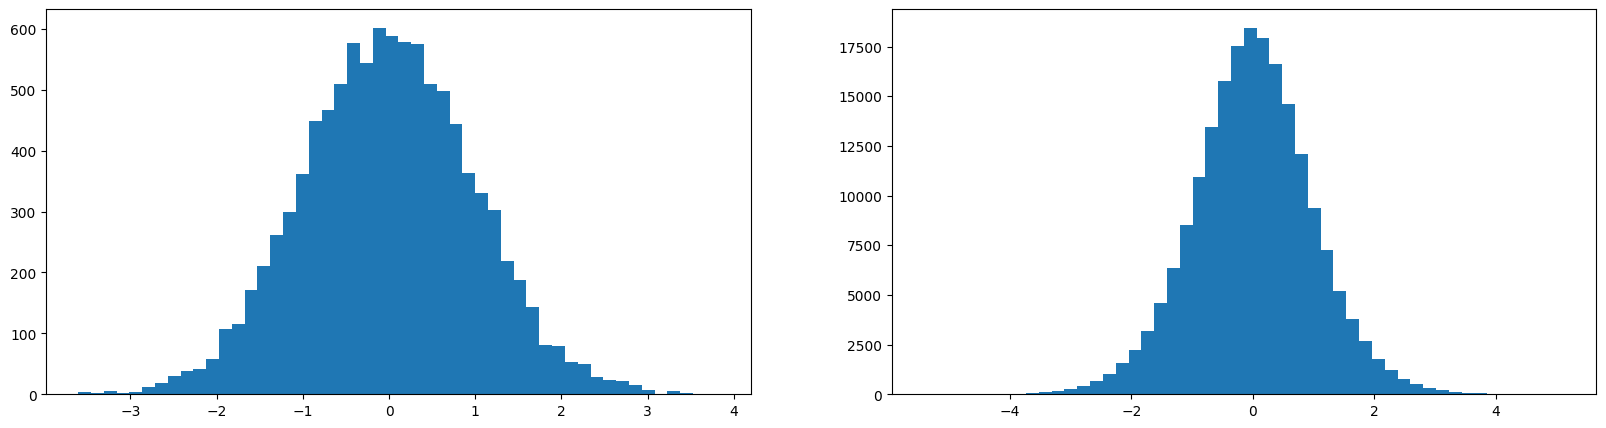

In [138]:
# fac = 1/sqrt(fan in) to maintain a normalised guassian or sqrt(2/fan in) for relu. sqrt(2) is refered to the gain. is 5/3 for tanh
fac = 1/10**0.5
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * fac # 200 neurons with input 10
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50);

## Batch Normalization

In [139]:
# want to keep everything going to the tanh ~gaussain

# bacth mean of each neurons activation 
batch_mean = hpreact.mean(dim=0, keepdim=True)
batch_std = hpreact.std(dim=0, keepdim=True)
hpreact.shape, batch_mean.shape, batch_std.shape

# standardize over the batch but need to allow this guassian to shift the gussian in width and center 
# use a batch_norm gain and bias which will be trained for this

# Calculating the batch norm couples all the examples in the batch which is a pain for regularization and is computationally 
# expensive. 

# The paper just actually calculates the batch norm over the full training set and uses this for evaluation and it doesnt work 
# too badly. They actually calcualte a running mean and use that.   



(torch.Size([32, 200]), torch.Size([1, 200]), torch.Size([1, 200]))

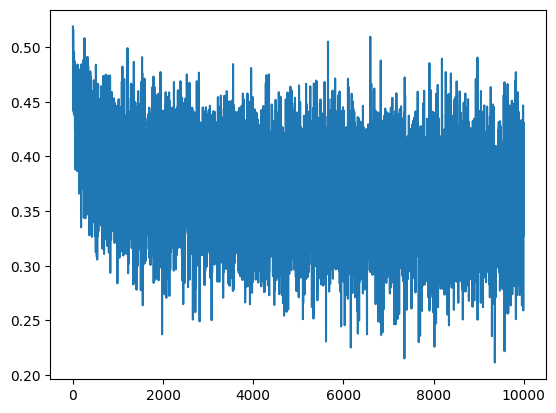

In [140]:
plt.plot(lossi)

In [154]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.3496146202087402
val 2.3603951930999756


In [113]:
# sample from model 
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context by taking the first off and adding the new one on:
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample a '.' stop the word
        if ix == 0:
            break 
            
    print(''.join(itos[i] for i in out))

carmahxani.
havif.
jario.
taty.
skandone.
rahnil.
delsaha.
kaqui.
nellana.
chaiiv.
kaleigh.
ham.
joie.
quinton.
lilea.
jadel.
waythonielrisi.
jace.
pilson.
eddeli.
